## Data Preparation
To begin this exploratory analysis, first use `matplotlib` to import libraries and define functions for plotting the data.

In [1]:
import pandas as pd
import os

In [14]:
# import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from collections import Counter
from keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelEncoder 
from keras.utils import to_categorical
import math

Using TensorFlow backend.


In [2]:
DATASET_PATH = "myntradataset/"
print(os.listdir(DATASET_PATH))

['styles.csv', 'images']


In [15]:
df = pd.read_csv(DATASET_PATH + "styles.csv", error_bad_lines=False)
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\nSkipping line 10264: expected 10 fields, saw 11\nSkipping line 10427: expected 10 fields, saw 11\nSkipping line 10905: expected 10 fields, saw 11\nSkipping line 11373: expected 10 fields, saw 11\nSkipping line 11945: expected 10 fields, saw 11\nSkipping line 14112: expected 10 fields, saw 11\nSkipping line 14532: expected 10 fields, saw 11\nSkipping line 15076: expected 10 fields, saw 12\nSkipping line 29906: expected 10 fields, saw 11\nSkipping line 31625: expected 10 fields, saw 11\nSkipping line 33020: expected 10 fields, saw 11\nSkipping line 35748: expected 10 fields, saw 11\nSkipping line 35962: expected 10 fields, saw 11\nSkipping line 37770: expected 10 fields, saw 11\nSkipping line 38105: expected 10 fields, saw 11\nSkipping line 38275: ex

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012.0,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012.0,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012.0,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016.0,Casual,Skagen Men Black Watch,30039.jpg


In [16]:
df.shape

(44424, 11)

In [17]:
df.articleType.value_counts()

Tshirts                      7067
Shirts                       3217
Casual Shoes                 2845
Watches                      2542
Sports Shoes                 2036
Kurtas                       1844
Tops                         1762
Handbags                     1759
Heels                        1323
Sunglasses                   1073
Wallets                       936
Flip Flops                    914
Sandals                       897
Briefs                        849
Belts                         813
Backpacks                     724
Socks                         686
Formal Shoes                  637
Perfume and Body Mist         613
Jeans                         609
Shorts                        547
Trousers                      530
Flats                         500
Bra                           477
Dresses                       464
Sarees                        427
Earrings                      416
Deodorant                     347
Nail Polish                   329
Lipstick      

In [18]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(5, 5)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return DATASET_PATH+"images/"+img

def load_image(img, resized_fac = 1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized

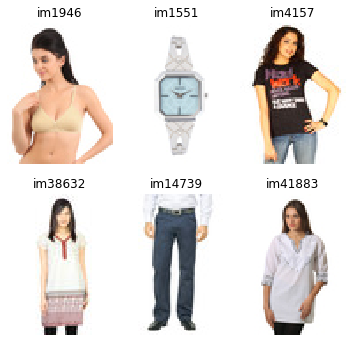

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

The Dataset is made up of different items that can be found in a marketplace. The idea is to use embeddings to search for similarity and find similar items just using the image.

## Use Pre-Trained Model to Recommendation

In [20]:
import tensorflow as tf
import keras
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
tf.__version__

'2.1.0'

In [21]:
# Input Shape
img_width, img_height, _ = 60, 80, 3 #load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

/home/bjit/AI/Jupyter/env/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2, 3, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [27]:
def get_embedding(model, img_name):
    # Reshape
    if os.path.exists(img_path(img_name)):
        img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
        # img to Array
        x   = image.img_to_array(img)
        # Expand Dim (1, w, h)
        x   = np.expand_dims(x, axis=0)
        # Pre process Input
        x   = preprocess_input(x)
        return model.predict(x).reshape(-1)
    else:
        return []

Get item Embedding

In [23]:
emb = get_embedding(model, df.iloc[0].image)
emb.shape

(2048,)

(80, 60, 3)
[0.         5.387988   0.11512393 ... 0.         0.         0.8515614 ]


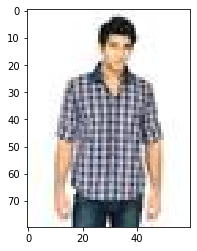

In [24]:
img_array = load_image(df.iloc[0].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [25]:
df.shape

(44424, 11)

Get Embedding for all itens in dataset

In [28]:
%%time
#import swifter

# Parallel apply
df_sample      = df#.sample(10)
map_embeddings = df_sample['image'].apply(lambda img: get_embedding(model, img))
df_embs        = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

(44424, 2048)
CPU times: user 1h 41min 29s, sys: 9min 8s, total: 1h 50min 38s
Wall time: 31min 2s


In [29]:
df_embs.head(5)

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0.000000,5.387988,0.115124,0.000000,0.0,0.000000,0.279430,1.604960,7.751400,0.0,...,0.547648,0.000000,0.243479,8.325708,0.123172,0.000000,5.372022,0.000000,0.000000,0.851561
1,0.800629,1.640910,0.000000,3.737655,0.0,0.000000,1.445452,2.499522,9.216043,0.0,...,0.000000,0.000000,0.456532,7.377114,0.000000,0.000000,3.361512,2.474394,1.173676,1.878182
2,0.000000,2.162907,0.000000,0.000000,0.0,0.692489,0.000000,0.000000,0.221097,0.0,...,0.000000,6.413446,0.000000,0.000000,0.000000,0.000000,0.680426,0.000000,2.713659,0.748437
3,0.718708,3.872288,0.000000,6.476261,0.0,0.000000,0.000000,0.904043,8.560805,0.0,...,9.020041,0.000000,0.000000,1.082418,0.000000,0.627495,0.000000,4.718786,1.852989,7.612549
4,0.000000,2.933397,0.368637,1.933430,0.0,2.741759,0.608685,3.647114,5.022531,0.0,...,2.598805,0.000000,0.000000,6.778734,1.075730,0.000000,0.948183,1.182621,0.000000,0.000000


In [41]:
df_embs[[(sum(x) <= 0) for ind, x in df_embs.iterrows()]]

,0,1,2,3,4,5,6,7,8,9,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047


In [42]:
print(len(df_embs) )

44424


In [43]:
from scipy import spatial

In [44]:
result = [ 1 - spatial.distance.cosine(df_embs.iloc[0], df_embs.iloc[i]) for i in range(len(df_embs))]

In [45]:
len(result)

44424

#### Compute Similarity Between Items

In [23]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
from sklearn.metrics.pairwise import pairwise_distances

# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[0.99999946, 0.52930576, 0.19709253, 0.47326314],
       [0.52930576, 1.        , 0.21934605, 0.78175217],
       [0.19709253, 0.21934605, 0.9999999 , 0.21135587],
       [0.47326314, 0.78175217, 0.21135587, 1.        ]], dtype=float32)

#### Recommender Similar Items

In [46]:
indices = pd.Series(range(len(df)), index=df.index)

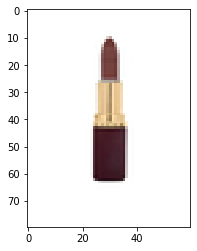

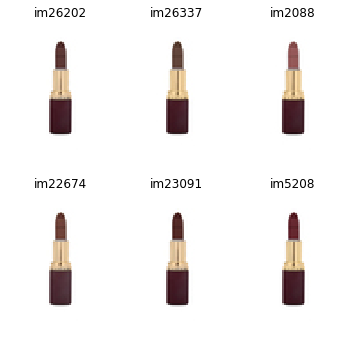

In [61]:
# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender1(idx, df, options, top_n = 5):
    sim_idx    = indices[idx]
    cosine_sim = [ 1 - spatial.distance.cosine(df_embs.iloc[sim_idx], df_embs.iloc[i]) for i in range(len(df_embs))]
    
    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:]
    
    filteredIndices = set();
    
    if len(options) > 0:
        it = 0
        for column in options:
            if it == 0:
                filteredIndices = set(df.index[df[column]== options[column]].tolist())
            else:
                filteredIndices = filteredIndices & set(df.index[df[column]== options[column]].tolist())
            it = it + 1
            
        filteredIndices = list(filteredIndices)
#         print(len(filteredIndices) )
    else:
        filteredIndices = list(indices.index)

    
    idx_rec = []
    idx_sim = []
    count_sim = 0
    
    for i in sim_scores:
        if i[0] in filteredIndices:
            idx_rec.append(i[0])
            idx_sim.append(i[1])
            count_sim = count_sim + 1
            
            if count_sim >= top_n:
                break
            
    
    idx_rec = indices.iloc[idx_rec].index
    plt.imshow(cv2.cvtColor(load_image(df.iloc[idx].image), cv2.COLOR_BGR2RGB))
    
    
    if(len(idx_rec) <= 0):
        print('No matching item found for', options)
        return
    
    plot_row = math.ceil(len(idx_sim)/3)
    plot_col = min(3, len(idx_sim))
        # Plot
        #===================
        # generation of a dictionary of (title, images)
    figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
        # plot of the images in a figure, with 2 rows and 3 columns
    if len(figures):
        plot_figures(figures, plot_row, plot_col)

get_recommender1(19572, df, {}, top_n = 6)

In [63]:
df.iloc[19572]

id                                               55048
gender                                           Women
masterCategory                           Personal Care
subCategory                                       Lips
articleType                                   Lipstick
baseColour                                      Purple
season                                          Spring
year                                              2017
usage                                              NaN
productDisplayName    Lakme Enrich Satins Lipstick 138
image                                        55048.jpg
Name: 19572, dtype: object

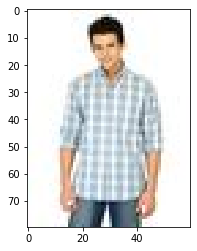

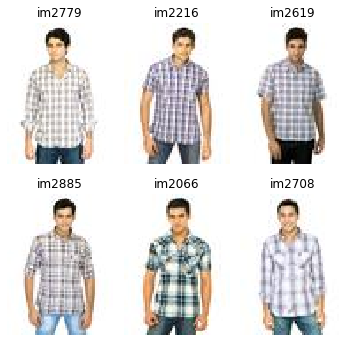

In [28]:

# Function that get movie recommendations based on the cosine similarity score of movie genres
def get_recommender(idx, df, options, top_n = 5):
    sim_idx    = indices[idx]
    
    filteredIndices = set();
    
    if len(options) > 0:
        it = 0
        for column in options:
            if it == 0:
                filteredIndices = set(df.index[df[column]== options[column]].tolist())
            else:
                filteredIndices = filteredIndices & set(df.index[df[column]== options[column]].tolist())
            it = it + 1
            
        filteredIndices = list(filteredIndices)
#         print(len(filteredIndices) )
    else:
        filteredIndices = list(indices.index)
    
    
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:]
    
    idx_rec = []
    idx_sim = []
    count_sim = 0
    
    for i in sim_scores:
        if i[0] in filteredIndices:
            idx_rec.append(i[0])
            idx_sim.append(i[1])
            count_sim = count_sim + 1
            
            if count_sim >= top_n:
                break
            
    
    idx_rec = indices.iloc[idx_rec].index
    plt.imshow(cv2.cvtColor(load_image(df.iloc[idx].image), cv2.COLOR_BGR2RGB))
    
    
    if(len(idx_rec) <= 0):
        print('No matching item found for', options)
        return
    
    plot_row = math.ceil(len(idx_sim)/3)
    plot_col = min(3, len(idx_sim))
        # Plot
        #===================
        # generation of a dictionary of (title, images)
    figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
        # plot of the images in a figure, with 2 rows and 3 columns
    if len(figures):
        plot_figures(figures, plot_row, plot_col)

get_recommender(2993, df, {"baseColour": "White"}, top_n = 6)

In [16]:
base_color_filter = df['baseColour']=='Blue'

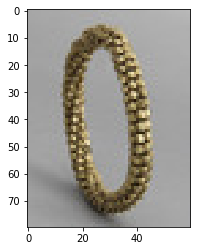

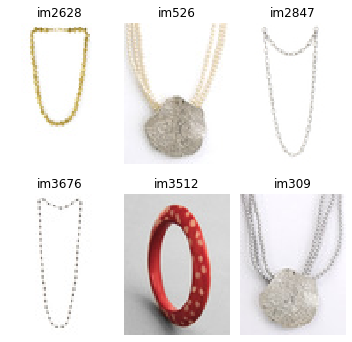

In [26]:
# Idx Item to Recommender
idx_ref = 26

# Recommendations
get_recommender(idx_ref, df, {}, top_n = 6)

In [26]:
df[df.index == 554]

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
554,25527,Women,Apparel,Topwear,Shirts,Green,Summer,2012,Casual,Wrangler Women Stella Green Shirt,25527.jpg


In [25]:
df[df.subCategory == 'Shoe'][df.baseColour == 'Black']

/home/bjit/AI/Jupyter/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image


**Search for items similar to the reference to recommend. Apparently it's working!**

In [ ]:
idx_ref = 879

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, {}, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

In [ ]:
idx_ref = 987

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, {}, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

In [ ]:
idx_ref = 3524

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, {}, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

# Fine tune feature extractor

In [ ]:
image_meta = pd.read_csv(DATASET_PATH+'styles.csv',error_bad_lines=False)

In [ ]:
image_meta.shape

In [ ]:
image_meta.head(5)

In [ ]:
image_meta.year.nunique()